# Pre-Processing and Training Data<a id='Pre-Processing_and_Training_Data'></a>

#  Contents<a id='Contents'></a>
* [1. Imports](#1._Imports)
* [2. Load The Data](#2._Load_Data)
* [3. Train/Test Split](#3._Train/Test_Split)
* [4. Scaling](#4._Scaling)
* [5. Logistic Model](#5._Logistic_Model)
    * [5.1 Train Test](#5.1_Train_test)
    * [5.2 Tuning](#5.2_Tuning)
    * [5.3 Pipeline](#5.3_Pipeline)
    * [5.4 Refining model using GridSearchCV](#5.4_Refine)
        * [5.4.1 Create Grid](#5.4.1_Create_Grid)
        * [5.4.2 Summarize Result](#5.4.2_Summarize_Result)
        * [5.4.3 Check best params](#5.4.3_Check_best_params)
    * [5.5 Recreate_model_with_best_param](#5.5_Recreate_model)
    * [5.6 Confusion matrix with best param](#5.6_Confusion_matrix)
    * [5.7 ROC/AUC Score](#5.7_ROC_AUC)
* [6. Random Forest Model](#6._Logistic_Model)
    * [6.1 Train Test](#6.1_Train_test)
    * [6.2 Pipeline](#6.2_Pipeline)
    * [6.3 Refining model using GridSearchCV](#6.4_Refine)
        * [6.3.1 Create Grid](#6.3.1_Create_Grid)
        * [6.3.2 Summarize Result](#6.3.2_Summarize_Result)
        * [6.3.3 Check best params](#6.3.3_Check_best_params)
    * [6.4 Recreate_model_with_best_param](#6.4_Recreate_model)
    * [6.5 ROC/AUC Score](#6.5_ROC_AUC)
* [7. XG_Boost Model](#7._XG_Boost_Model)
    * [7.1 Train Test](#7.1_Train_test)
    * [7.2 Refining model using GridSearchCV](#7.2_Refine)
        * [7.2.1 Create Grid](#7.2.1_Create_Grid)
        * [7.2.2 Check best params](#7.2.2_Check_best_params)
    * [7.3 Recreate_model_with_best_param](#7.3_Recreate_model)
    * [7.4 ROC/AUC Score](#7.4_ROC_AUC)
* [8.Learning Curve](#8._Learning_Curve)  
* [9.Save Model](#9._Save_Model)  
    

    



We will be using :
1. Logistic Regression
2. Random Forest
3. XG Boost model
to predict whether or not a transaction is fraud

## 1. Imports <a id='1._Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.feature_selection import VarianceThreshold

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score
from sklearn.pipeline import make_pipeline

## 2. Load The Data<a id='2._Load_Data'></a>

In [2]:
df = pd.read_csv('data/transaction_data_cleaned.csv')
print(df.shape)
df.head().T

(731560, 27)


,0,1,2,3,4
creditLimit,50000,20000,10000,2500,250
availableMoney,50000,20000,10000,2500,250
merchantName,Washington Post,cheapfast.com,discount.com,Fast Repair,staples.com
acqCountry,US,US,US,US,US
merchantCountryCode,US,US,US,US,US
posEntryMode,9,5,2,5,5
posConditionCode,1,1,8,1,1
merchantCategoryCode,subscriptions,online_retail,online_retail,auto,online_retail
transactionType,PURCHASE,PURCHASE,PURCHASE,ADDRESS_VERIFICATION,PURCHASE
cardPresent,False,False,False,False,False


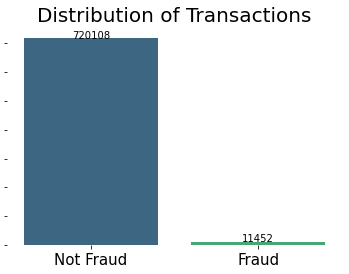

In [3]:
# using seaborns countplot to show distribution of fraud in dataset
fig, ax = plt.subplots()
g = sns.countplot(x=df.isFraud, palette='viridis')
g.set_xticklabels(['Not Fraud', 'Fraud'])
g.set_yticklabels([])

# function to show values on bars
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
show_values_on_bars(ax)

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('Distribution of Transactions', fontsize=20)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.show()

We have a very imbalanced data as we have noted during our cleaning process. We will need to change our scoring metric. That is, we should not use accuracy score since we will get a high accuracy score even if we just predict that all of our transactions are not fraud

## 3 Train/Test Split<a id='3._Train/Test_Split'></a>

In [4]:
df.merchantName.value_counts()

AMC                 35235
EZ Putt Putt        28655
Uber                23372
Lyft                23294
alibaba.com         15653
                    ...  
TMobile Wireless       47
Verizon Wireless       45
ATT                    44
Duane Reed             28
My Fitness              7
Name: merchantName, Length: 205, dtype: int64

In [5]:
# double check data types
df.dtypes

creditLimit                 float64
availableMoney              float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                  int64
posConditionCode              int64
merchantCategoryCode         object
transactionType              object
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
CVVMatch                       bool
containsCom                    bool
lengthOfLast4Digits           int64
creditLimitCategory           int64
transactionAmountBoxcox     float64
availableMoneyBoxcox        float64
currentBalanceBoxcox        float64
transactionTime               int64
transactionMonth              int64
dayOfTransaction              int64
expiryYear                    int64
expiryMonth                   int64
accountOpenYear               int64
accountOpenMonth              int64
yearOfLastAddressChange       int64
dtype: object

In [6]:
# check for null values
df.isnull().sum()

creditLimit                 0
availableMoney              0
merchantName                0
acqCountry                  0
merchantCountryCode         0
posEntryMode                0
posConditionCode            0
merchantCategoryCode        0
transactionType             0
cardPresent                 0
expirationDateKeyInMatch    0
isFraud                     0
CVVMatch                    0
containsCom                 0
lengthOfLast4Digits         0
creditLimitCategory         0
transactionAmountBoxcox     0
availableMoneyBoxcox        0
currentBalanceBoxcox        0
transactionTime             0
transactionMonth            0
dayOfTransaction            0
expiryYear                  0
expiryMonth                 0
accountOpenYear             0
accountOpenMonth            0
yearOfLastAddressChange     0
dtype: int64

In [7]:
# Only take the first 100000 rows to test. delete this line later
df = df.sample(n = 150000) 

### One Hot encoding

It simply creates additional features based on the number of unique values in the categorical feature. Every unique value in the category will be added as a feature.

In [8]:
dummy_cols = ['acqCountry','merchantCategoryCode','merchantCountryCode','transactionType','merchantName']
df = pd.get_dummies(df, columns = dummy_cols)
df

,creditLimit,availableMoney,posEntryMode,posConditionCode,cardPresent,expirationDateKeyInMatch,isFraud,CVVMatch,containsCom,lengthOfLast4Digits,...,merchantName_ikea.com,merchantName_netflix.com,merchantName_oldnavy.com,merchantName_pottery-barn.com,merchantName_sears.com,merchantName_staples.com,merchantName_target.com,merchantName_walmart.com,merchantName_westelm.com,merchantName_williamssonoma.com
137635,50000.0,43692.01,9,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
99588,5000.0,1553.54,9,8,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
290964,7500.0,7500.00,9,8,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
290124,2500.0,1170.98,5,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
542895,50000.0,49960.12,9,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612140,15000.0,14175.26,90,1,True,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
428542,5000.0,866.69,2,1,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0
617236,500.0,250.97,5,1,False,False,False,True,True,4,...,0,0,0,0,1,0,0,0,0,0
621543,50000.0,17494.84,5,1,False,False,False,True,False,4,...,0,0,0,0,0,0,0,0,0,0


Drop column with variance of 0. That is column with all the same values

In [9]:
# X is everything but the target variable

X = df.drop(columns = 'isFraud')
selector = VarianceThreshold(threshold = 0)
selector.fit_transform(X)
y = df.isFraud


In [10]:
# 1. use train test split method
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=47)


# 2. Variance threshold on Xtrain
selector = VarianceThreshold(threshold = 0)
selector.fit_transform(X_train)

array([[7500.0, 1911.59, 80, ..., 0, 0, 0],
       [2500.0, 1738.71, 9, ..., 0, 0, 0],
       [15000.0, 10169.06, 80, ..., 0, 0, 0],
       ...,
       [2500.0, 283.69, 2, ..., 0, 0, 0],
       [2500.0, 2431.12, 9, ..., 0, 0, 0],
       [50000.0, 43322.22, 9, ..., 0, 0, 0]], dtype=object)

In [11]:
X_train.shape, X_test.shape

((105000, 255), (45000, 255))

In [12]:
X.dtypes

creditLimit                        float64
availableMoney                     float64
posEntryMode                         int64
posConditionCode                     int64
cardPresent                           bool
                                    ...   
merchantName_staples.com             uint8
merchantName_target.com              uint8
merchantName_walmart.com             uint8
merchantName_westelm.com             uint8
merchantName_williamssonoma.com      uint8
Length: 255, dtype: object

### Check for extreme Multicolinearity

The Dummy Variable Trap leads to the problem known as multicollinearity. Multicollinearity occurs where there is a dependency between the independent features. Multicollinearity is a serious issue in machine learning models like Linear Regression and Logistic Regression.

One of the common ways to check for multicollinearity is the Variance Inflation Factor (VIF):

- VIF=1, Very Less Multicollinearity
- VIF<5, Moderate Multicollinearity
- VIF>5, Extreme Multicollinearity (This is what we have to avoid)

In [13]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

# def calc_vif(X):

#     # Calculating VIF
#     vif = pd.DataFrame()
#     vif["variables"] = X.columns
#     vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

#     return(vif)

# calc_vif(X)



## 4. Scaling<a id='4._Scaling'></a>




#### scale data to prepare for model creation

In [14]:
# #1. Call the StandardScaler`s fit method on `X_tr` to fit the scaler
scaler = StandardScaler().fit(X_train)

# 2.Transform the actual X_train and X_test data to be standard normal
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Variance threshold on Xtrain_scaled
selector = VarianceThreshold(threshold = 0)
selector.fit_transform(X_train_scaled)

array([[-2.82410738e-01, -4.89432168e-01,  4.24319114e+00, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02],
       [-7.09576285e-01, -5.08932075e-01, -4.92961828e-04, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02],
       [ 3.58337583e-01,  4.41964734e-01,  4.24319114e+00, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02],
       ...,
       [-7.09576285e-01, -6.73050276e-01, -4.18884352e-01, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02],
       [-7.09576285e-01, -4.30832060e-01, -4.92961828e-04, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02],
       [ 3.34849641e+00,  4.18145765e+00, -4.92961828e-04, ...,
        -1.47035413e-01, -2.39114050e-02, -2.24725792e-02]])

## 5. Logisitic Model<a id='5._Logistic_Model'></a>


### 5.1 Train test<a id='5.1_Train_test'></a>

    
    

In [15]:
clf = LogisticRegression()

In [16]:
clf.fit(X_train_scaled, y_train)

/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [17]:
from sklearn.metrics import roc_auc_score

# check score on the test data
print("accuracy: ",accuracy_score(y_test, clf.predict(X_test_scaled)))
print("roc_auc score: ",roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1]))
print("recall: ",recall_score(y_test, clf.predict(X_test_scaled)))


accuracy:  0.9845333333333334
roc_auc score:  0.7336826505377683
recall:  0.0


In [18]:
# confusion matrix 
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test_scaled)))

,0,1
0,44304,0
1,696,0


We have a very good accuracy even without setting the parameter. This is because of the imbalance data. 
We are predicting that everything is not fraud.

### 5.2 Tune the Model<a id='5.2_Tuning'></a>

Lets tune the model to take into account the imbalanceness and see if we can get higher f1_score. In Logistic Regression, the most important parameter to tune is the regularization parameter C. Note that the regularization parameter is not always part of the logistic regression model.



We use the following cross_val_score function to perform K-fold cross-validation and apply a scoring function to each test fold.

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.metrics import average_precision_score

# prepare the cross-validation procedure
cv = KFold(n_splits=5, random_state=1, shuffle=True)

# create model
clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)

/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

For each C:
1. Create a logistic regression model with that value of C
2. Find the average score: roc_auc, recall, accuracy for this model using the cross_val_score function **only on the training set** (X_train_scaled, y_train)

### Tuning 1: class_weight = 'balanced'

In [22]:
# We need to binarize y_train if we want to do recall scoring on cross_val_score
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit_transform(y_train)


scores_type = ['roc_auc', 'recall']
Cs = [0.001, 0.1, 10, 100]
max_score = 0
for C in Cs:
        # 1.we pass in C as the argument for regularization parameter C
        clf = LogisticRegression(C = C, class_weight = "balanced" )
        
        print("C :",C)
        for score_type in scores_type:
            # 2. take the score of the model above
            # print 
            print(score_type) 
            mean_score = mean(cross_val_score(clf, X_train_scaled, y_train, scoring = score_type, cv=cv, n_jobs=-1))
            print(mean_score)
        
        print("\n")



C : 0.001
roc_auc
0.7414561498695544
recall
0.6992707487015555


C : 0.1
roc_auc
0.740544654493407
recall
0.7005103289829058


C : 10
roc_auc
0.7402377976208625
recall
0.7005103289829058


C : 100
roc_auc
0.740221407010586
recall
0.7011073439082789




At C=0.001 we have the highest ROC_AUC score and recall score

### Tuning 2: Oversampled data
#### Let's try oversampled data to see if this changes our Logistic Regression performance

In [23]:
from imblearn.over_sampling import ADASYN
from collections import Counter

ada = ADASYN(random_state=42)

# 1. get oversampled data
X_ada, y_ada = ada.fit_resample(X_train_scaled, y_train)

# 2. check new class distribution
print(Counter(y_ada))


Counter({False: 103373, True: 103119})


In [24]:
# 1. Create new Logistic model
# We don't need to add argument for weight_score since we are doing this manually
clf = LogisticRegression(C=0.001)

# # 2. train on the balanced oversampled data
clf.fit(X_ada, y_ada)


LogisticRegression(C=0.001)

In [25]:
# scores on the test data
print('Oversampling recall score: ', 
      recall_score(y_test, clf.predict(X_test_scaled)))

print('Oversampling ROC_AUC score: ', 
      roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1]))


Oversampling recall score:  0.6594827586206896
Oversampling ROC_AUC score:  0.7173263849972812


This is worse than what we get above!

### Tuning 3: Undersampled data

In [26]:
from imblearn.under_sampling import RandomUnderSampler

# instantiating the random undersampler
rus = RandomUnderSampler() 

# resampling X, y
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)

# new class distribution
print(Counter(y_rus))


Counter({False: 1627, True: 1627})


In [27]:
# Create new Logistic model and train on the balanced undersampled data
# lb.fit(y_rus)
clf3 = LogisticRegression(C=0.001)
clf3.fit(X_rus, y_rus)

# check recall score on training data
print('Undersampling set Recall: ', 
      recall_score(y_train, clf3.predict(X_train_scaled)))

print('Undersampling ROC_AUC score: ', 
      roc_auc_score(y_train, clf3.predict_proba(X_train_scaled)[:,1]))

print('mean_train3',mean(cross_val_score(clf3, X, y, scoring = 'recall', cv=cv, n_jobs=-1)))

Undersampling set Recall:  0.7480024585125998
Undersampling ROC_AUC score:  0.755753433611155
mean_train3 0.0


Undersampling gives a much better score on test data. Lets try this again after our GridSearchCV

### 5.3 Pipeline<a id='5.3_Pipeline'></a>

#### 5.3.1 Define the pipeline with RandomUnderSampler

In [28]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
pipe_imb = make_pipeline_imb(StandardScaler(),RandomUnderSampler(),LogisticRegression())


#### 5.3.2 Fit the pipeline

In [29]:
pipe_imb.fit(X_train, y_train)


/Users/sherlyhartono/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomundersampler', RandomUnderSampler()),
                ('logisticregression', LogisticRegression())])

In [30]:
# check list of estimator for gridCV
pipe_imb.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomundersampler', 'logisticregression', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomundersampler__random_state', 'randomundersampler__replacement', 'randomundersampler__sampling_strategy', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'logisticregression__n_jobs', 'logisticregression__penalty', 'logisticregression__random_state', 'logisticregression__solver', 'logisticregression__tol', 'logisticregression__verbose', 'logisticregression__warm_start'])

### 5.4 Refine Model using GridSearchCV<a id='5.4_Refine'></a>

##### 5.4.1 Create grid<a id='5.4.1_Create_Grid'></a>


Which scoring should we use?

With highly imbalance data and when there is a high cost associated with False Negative (Fraud but classified as not fraud) we use Recall.
Recall calculates how many of the Actual Positives(Fraud) our model capture through labeling it as Positive (Truly Fraud)

<img src="data/recall.png">

In [32]:
solvers = ['liblinear', 'newton-cg', 'lbfgs']
penalty = ['l2']
c_values = [0.001, 0.1, 100]

grid = dict(logisticregression__solver = solvers,
            logisticregression__penalty = penalty,
            logisticregression__C = c_values)

grid_search = GridSearchCV(pipe_imb, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)

grid_result = grid_search.fit(X_train, y_train)


##### 5.4.2 Summarize Results<a id='5.4.2_Summarize_Result'></a>

In [33]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.732855 using {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
0.731800 (0.013109) with: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.732855 (0.014837) with: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
0.730631 (0.016350) with: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
0.722904 (0.009753) with: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.723131 (0.009875) with: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'newton-cg'}
0.720912 (0.007908) with: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
0.722307 (0.009249) with: {'logisticregression

##### 5.4.3 Check best params<a id='5.4.3_Check_best_params'></a>

In [34]:
# See if best C is the same as before gridCvShttp://localhost:8890/notebooks/CreditCardFraud/PreprocessingTraining.ipynb#earch
grid_search.best_params_


{'logisticregression__C': 0.001,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'newton-cg'}

### 5.5 Predict and get scores for the test datas <a id='5.5_Recreate_model'></a>

Recall score is the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.

#### 1. Scaled data with class_weight

In [35]:
clf = LogisticRegression(C = 0.001,
                         penalty = 'l2',
                         solver = 'liblinear',
                         class_weight = "balanced")

clf.fit(X_train_scaled, y_train)

# 3. predict
y_test_pred_weight = clf.predict(X_test_scaled)

# 4. calculate accuracy
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1])
recall = recall_score(y_test, y_test_pred_weight)

print("roc_auc: ",roc_auc)
print("recall: ",recall)

roc_auc:  0.7332135172143974
recall:  0.7112068965517241


#### 2. Undersampled Test score

In [36]:
from sklearn.metrics import classification_report

clf2 = LogisticRegression(C = 0.001,
                         penalty = 'l2',
                         solver = 'liblinear' )


# 2. fit the model using oversampled data.
clf2.fit(X_rus, y_rus)

# 3. predict
y_test_pred_rus = clf2.predict(X_test_scaled)


# 4. calculate accuracy
roc_auc = roc_auc_score(y_test, clf2.predict_proba(X_test_scaled)[:,1])
recall = recall_score(y_test, y_test_pred_rus)


print("roc_auc: ",roc_auc)
print("recall: ",recall)

roc_auc:  0.72317894157607
recall:  0.7629310344827587


In [37]:
print(classification_report(y_test, y_test_pred_rus))

              precision    recall  f1-score   support

       False       0.99      0.55      0.71     44304
        True       0.03      0.76      0.05       696

    accuracy                           0.55     45000
   macro avg       0.51      0.65      0.38     45000
weighted avg       0.98      0.55      0.69     45000



Undersampling data gives a much better recall score thant using original scaled data

Let's compare with **Training score**

In [38]:
# 1. predict
y_train_pred_rus = clf2.predict(X_train_scaled)

# 2. calculate accuracy
roc_auc = roc_auc_score(y_train, clf2.predict_proba(X_train_scaled)[:,1])
recall = recall_score(y_train, y_train_pred_rus)

print("roc_auc: ",roc_auc)
print("recall: ",recall)

roc_auc:  0.7529045064135452
recall:  0.7959434542102028


There is not much difference between test and  train prediction. We can keep this model

### 5.6 Confusion matrix with best params<a id='5.6_Confusion_matrix'></a>

In [39]:
# Define plot confusion matrix function
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


### 1. Confusion Matrix Result trained on data with class_weight

Confusion matrix, without normalization
[[28860 15444]
 [  201   495]]


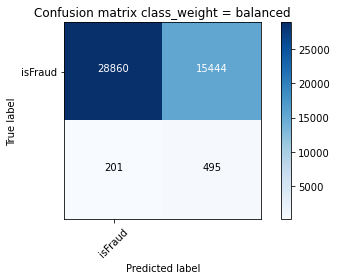

In [40]:
# compute confusion matrix and plot. Check if its making better prediction
cm = confusion_matrix(y_test, y_test_pred_weight)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for 'Survived'
plt.figure()
plot_confusion_matrix(cm, classes=['isFraud'],
                      title='Confusion matrix class_weight = balanced')

### 2. Confusion Matrix Result trained on undersampled data

Confusion matrix, without normalization
[[24209 20095]
 [  165   531]]


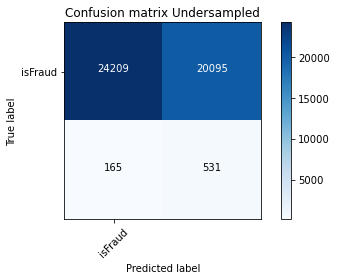

In [41]:
cm2 = confusion_matrix(y_test, y_test_pred_rus)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for 'Survived'
plt.figure()
plot_confusion_matrix(cm2, classes=['isFraud'],
                      title='Confusion matrix Undersampled')

We can see that the false negative is much lower in undersampled data (152) compared to oversampled data (201). Although the false positive is higher in the undersampled data (20400) vs oversampled (15965)

### 5.7 ROC/AUC Score<a id='5.7_ROC_AUC'></a>


In [42]:
from sklearn.metrics import roc_curve, auc, plot_precision_recall_curve
# Calculate ROC for the model
# calculate the fpr and tpr for all thresholds of the classification

# 1. predict probabilities for test data
# (kind of like getting the the proportion)
probs = clf2.predict_proba(X_test_scaled)

# 2. keep probabilities of positive class only
preds = probs[:,1]

# 3. get ROC curve
fpr, tpr, threshold = roc_curve(y_test, preds)

# 4. compute AUC score
roc_auc = auc(fpr, tpr)



In [43]:
# plot roc function
def plot_roc_curve(fpr,tpr):
    #title
    plt.title('Receiver Operating Characteristic (Undersampled data model)')
    
    # plot curve
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    
    # plot fpr=tpr 
    plt.plot([0, 1], [0, 1],'r--')
    
    #limit
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    #label
    plt.legend(loc = 'lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

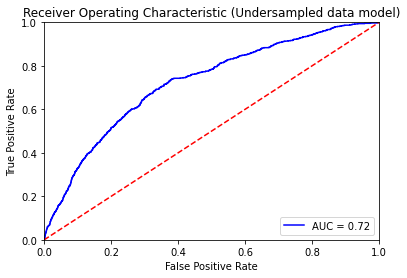

In [44]:
plot_roc_curve(fpr,tpr)

### Precision-Recall curve

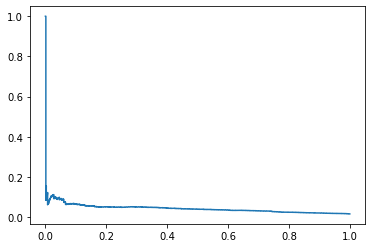

In [46]:
# Question why is precision recall curve so bad
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve

precision1, recall1, thresholds1 = precision_recall_curve(y_test, preds)

# get precision recall auc score
precision_recall_auc1 = auc(recall1, precision1)

# plot recall precision curve
plt.plot(recall1, precision1, label = 'LogisticRegression = %0.3f' % precision_recall_auc1)



AUC score is fair. Let's see if we can improve uisng Random forest model

## 6. Random Forest Model<a id='6._Random_Forest_Model'></a>


### 6.1 Train Test<a id='6.1_Train_test'></a>

Create a new model trained on Oversampling

In [48]:
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier


# 1. create new pipeline for random forest classifier including downscaling
imba_pipeline = make_pipeline(RandomUnderSampler(),
                              StandardScaler(),
                              RandomForestClassifier())

# 2. get score
cross_val_score(imba_pipeline, X_train, y_train, scoring='roc_auc', cv=cv)


array([0.76, 0.77, 0.78, 0.77, 0.8 ])

### 6.3 Refining model using RandomSearchCV<a id='6.3_Refine'></a>

There are many parameters to tune. How do we start?
- n_estimators = number of trees in the forest
- max_features = max number of features considered for splitting a node
- max_depth = max number of levels in each decision tree
- min_samples_split = min number of data points placed in a node before the node is split
- min_samples_leaf = min number of data points allowed in a leaf node
- bootstrap = method for sampling data points (with or without replacement)

Lets used randomized search CV

#### 6.3.1 Create Grid<a id='6.3.1_Create_Grid'></a>

In [49]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 4)]

# 2. Number of features to consider at every split


# 3. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 15, num = 4)]
max_depth.append(None)

# 4. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 5. Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 5, 10]

# 6. Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight': ['balanced']}
print(random_grid)


{'n_estimators': [50, 200, 350, 500], 'max_depth': [2, 6, 10, 15, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 5, 10], 'bootstrap': [True], 'class_weight': ['balanced']}


In [50]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose=2,
                               scoring='roc_auc',
                               random_state=42,
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 114.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'class_weight': ['balanced'],
                                        'max_depth': [2, 6, 10, 15, None],
                                        'min_samples_leaf': [2, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 200, 350, 500]},
                   random_state=42, scoring='roc_auc', verbose=2)

#### 6.3.2 Check best params<a id='6.3.2_Check_best_params'></a>

In [51]:
# print winning set of hyperparameters
from pprint import pprint
pprint(rf_random.best_estimator_.get_params())
pprint(rf_random.best_score_)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
0.804279981674887


### 6.4 Recreate model with best param<a id='6.4_Recreate_model'></a>

In [52]:
rf_best = rf_random.best_estimator_

### 6.5 ROC/AUC Score<a id='6.5_ROC_AUC'></a>

In [ ]:
# Calculate ROC for the model
# calculate the fpr and tpr for all thresholds of the classification

# 1. predict probabilities for test data
# (kind of like getting the the proportion)
probs = rf_best.predict_proba(X_test_scaled)

# 2. keep probabilities of positive class only
preds2 = probs[:,1]

# 3. get ROC curve
fpr2, tpr2, threshold = roc_curve(y_test, preds2)

# 4. compute AUC score
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(loc = 'lower right')

We significantly increased our AUC scored compared to our previous logistic regression model!

# 7. XG Boost Model<a id='7_XG_Boost_Model'></a>


In [54]:
import xgboost as xgb


### 7.1 Train Test<a id='7.1_Train_test'></a>

### Train 1: use scale_pos_weight

In [55]:
# take into account imbalance data by modifying scale_pos_weight
clf_xg = xgb.XGBClassifier(scale_pos_weight=100)
clf_xg.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=100, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Let's check performance before tuning

In [56]:
# 1. Train 
# print roc_auc and recall score for training data
print('Train score')
print('Training recall score: ', 
      recall_score(y_train, clf_xg.predict(X_train_scaled)))

print('Training ROC_AUC score: ', 
      roc_auc_score(y_train, clf.predict_proba(X_train_scaled)[:,1]))


# 2. Test
print('Test score')
print('Test recall score: ', 
      recall_score(y_test, clf_xg.predict(X_test_scaled)))

print('Test ROC_AUC score: ', 
      roc_auc_score(y_test, clf.predict_proba(X_test_scaled)[:,1]))

Train score
Training recall score:  0.9870928088506453
Training ROC_AUC score:  0.7744360174462283
Test score
Test recall score:  0.5876436781609196
Test ROC_AUC score:  0.7332135172143974


There is huge difference between train and test score , it is overfitting

### Train 2: use undersampled data

In [58]:
clf_xg_rus = xgb.XGBClassifier()
clf_xg_rus.fit(X_rus, y_rus)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [59]:
# print roc_auc score for training data

cross_val_score(clf_xg_rus, X, y, scoring = 'roc_auc', cv=cv, n_jobs=-1)


array([0.8 , 0.78, 0.8 , 0.8 , 0.8 ])

Using undersampled data result in lower performance for training data but better performance on test data

### 7.2 Refining model using RandomSearch<a id='7.2_Refine'></a>

#### 7.2.1 Create Grid<a id='7.2.1_Create_Grid'></a>

In [60]:
clf_xg =xgb.XGBClassifier(tree_method = "exact", predictor = "cpu_predictor", verbosity=1,
                        objective='binary:logistic')

# Create parameter grid
parameters = {"scale_pos_weight" : [1, 25, 50, 75, 99],
              "learning_rate": [0.1, 0.01, 0.001],
              "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
              "max_depth": [2, 4, 7, 10],
              "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
              "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
              "reg_alpha": [0, 0.5, 1],
              "reg_lambda": [1, 1.5, 2, 3, 4.5],
              "min_child_weight": [1, 3, 5, 7],
              "n_estimators": [100, 1000, 1500, 2000]
             }

# n_estimators: 2000, 1500

In [61]:
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(clf_xg, param_distributions = parameters, scoring = "roc_auc",
                             cv = 5, verbose = 3, random_state = 40, n_jobs =-1 )

In [63]:
# Fit the model
model_xgboost = xgb_rscv.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 221.0min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 501.1min finished


In [64]:
print(X_train_scaled)

[[-2.82e-01 -4.89e-01  4.24e+00 ... -1.47e-01 -2.39e-02 -2.25e-02]
 [-7.10e-01 -5.09e-01 -4.93e-04 ... -1.47e-01 -2.39e-02 -2.25e-02]
 [ 3.58e-01  4.42e-01  4.24e+00 ... -1.47e-01 -2.39e-02 -2.25e-02]
 ...
 [-7.10e-01 -6.73e-01 -4.19e-01 ... -1.47e-01 -2.39e-02 -2.25e-02]
 [-7.10e-01 -4.31e-01 -4.93e-04 ... -1.47e-01 -2.39e-02 -2.25e-02]
 [ 3.35e+00  4.18e+00 -4.93e-04 ... -1.47e-01 -2.39e-02 -2.25e-02]]


#### 7.2.2 Check Best Params<a id='7.2.2_Check_best_params'></a>

In [65]:
# get best score
pprint(model_xgboost.best_estimator_.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.3,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 5,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 1000,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'objective': 'binary:logistic',
 'predictor': 'cpu_predictor',
 'random_state': 0,
 'reg_alpha': 0.5,
 'reg_lambda': 4.5,
 'scale_pos_weight': 25,
 'subsample': 0.5,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 1}


In [66]:
pprint(model_xgboost.best_score_)

0.7983473813453247


### 7.3 Recreate model with best param<a id='7.3_Recreate_model'></a>

In [67]:
# 1.create model 
xg_best = model_xgboost.best_estimator_

# 2. predict
y_pred3 = xg_best.predict_proba(X_test_scaled)[:,1]

### 7.4 ROC/AUC Score<a id='7.4_ROC_AUC'></a>

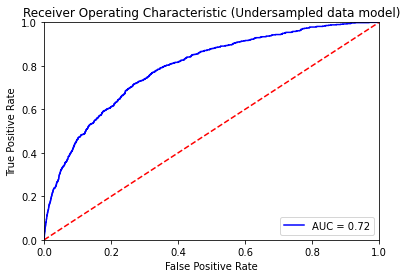

roc_auc best 0.7932057164865112


In [68]:
# 3. get ROC curve
fpr3, tpr3, threshold = roc_curve(y_test, y_pred3)

# 4. compute AUC score
roc_auc3 = auc(fpr3, tpr3)
plot_roc_curve(fpr3,tpr3)

roc_auc3 = roc_auc_score(y_test, y_pred3)
print('roc_auc best', roc_auc3)

Its performing worse than random forest

Lets try another classifier trained on undersampled data using best param

In [69]:
clf_undersampled = xgb.XGBClassifier(
     base_score = 0.5,
     booster= 'gbtree',
     colsample_bylevel= 1,
     colsample_bynode= 1,
     colsample_bytree= 1.0,
     gamma= 2,
     gpu_id= -1,
     importance_type= 'gain',
     learning_rate= 0.1,
     max_delta_step= 0,
     max_depth= 2,
     min_child_weight= 5,
     monotone_constraints= (),
     n_estimators= 500,
     n_jobs= 0,
     num_parallel_tree= 1,
     objective= 'binary:logistic',
     predictor= 'cpu_predictor',
     random_state= 0,
     reg_alpha= 0,
     reg_lambda= 4.5,
     scale_pos_weight= 75,
     subsample= 0.5,
     tree_method= 'exact',
     validate_parameters= 1,
     verbosity= 1)


In [70]:
clf_undersampled.fit(X_rus, y_rus)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=2,
              min_child_weight=5, missing=nan, monotone_constraints=(),
              n_estimators=500, n_jobs=0, num_parallel_tree=1,
              predictor='cpu_predictor', random_state=0, reg_alpha=0,
              reg_lambda=4.5, scale_pos_weight=75, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=1)

In [71]:
y_pred4 = clf_undersampled.predict_proba(X_test_scaled)[:,1]
roc_auc_score(y_test,y_pred4)

0.7319120824823684

It still doesnt do as well as RandomForest

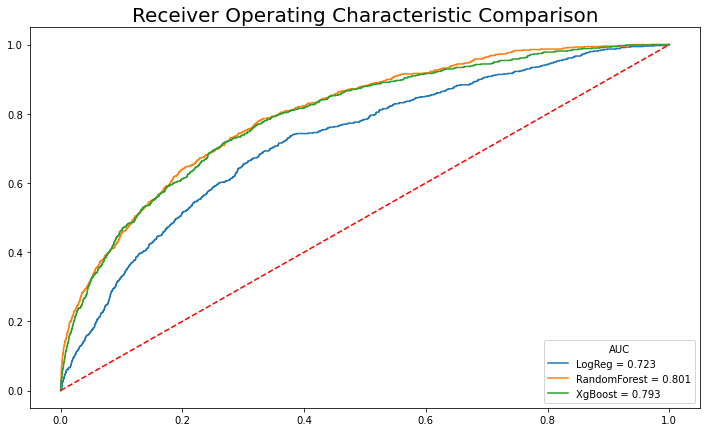

In [72]:
plt.figure(figsize=(12,7))
plt.title('Receiver Operating Characteristic Comparison', size=20)
plt.plot(fpr, tpr, label = 'LogReg = %0.3f' % roc_auc)
plt.plot(fpr2, tpr2, label = 'RandomForest = %0.3f' % roc_auc2)
plt.plot(fpr3, tpr3, label = 'XgBoost = %0.3f' % roc_auc3)
plt.plot([0, 1], [0, 1],'r--')
plt.legend(title='AUC', loc = 'lower right')

# Feature importance

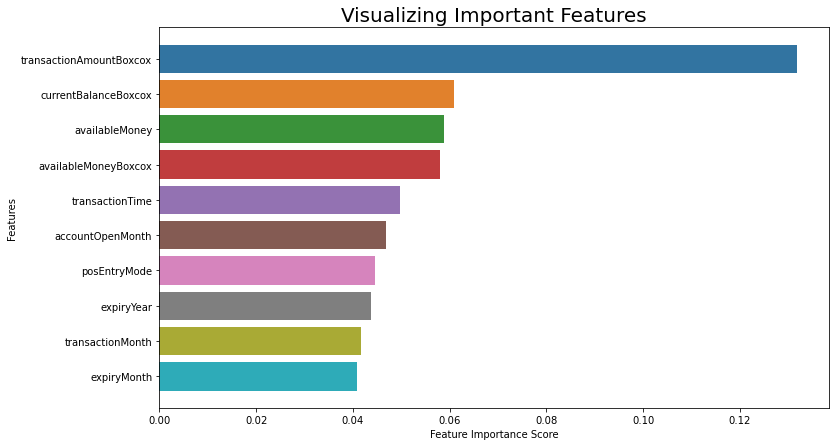

In [73]:
feature_imp = pd.Series(rf_best.feature_importances_, index=X_train.columns).sort_values(ascending=False)
_ = plt.figure(figsize=(12,7))
_ = sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
_ = plt.xlabel('Feature Importance Score')
_ = plt.ylabel('Features')
_ = plt.title('Visualizing Important Features', size=20)
_ = plt.plot()

# 8. Learning Curve<a id='8._Learning_Curve'></a>


Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The learning_curve function does this conveniently.

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [74]:
from sklearn.model_selection import learning_curve

In [78]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(xg_best, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

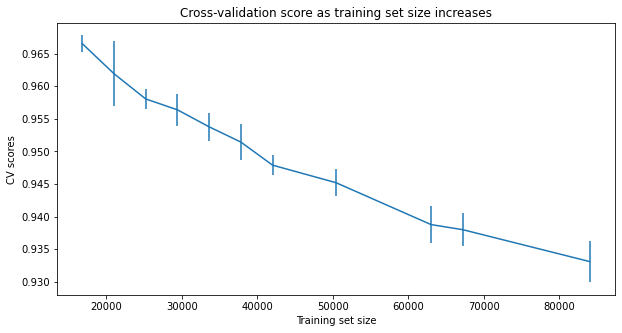

In [79]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

In [80]:
#Code task 28#
#This may not be "production grade ML deployment" practice, but adding some basic
#information to your saved models can save your bacon in development.
#Just what version model have you just loaded to reuse? What version of `sklearn`
#created it? When did you make it?
#Assign the pandas version number (`pd.__version__`) to the `pandas_version` attribute,
#the numpy version (`np.__version__`) to the `numpy_version` attribute,
#the sklearn version (`sklearn_version`) to the `sklearn_version` attribute,
#and the current datetime (`datetime.datetime.now()`) to the `build_datetime` attribute
#Let's call this model version '1.0'

import os
import pickle
import datetime
from sklearn import __version__ as sklearn_version

best_model = xg_best
best_model.version ='1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()
    
modelpath = '../CreditCardFraud/models'
if not os.path.exists(modelpath):
    os.mkdir(modelpath)
    
fraud_prediction_path = os.path.join(modelpath, 'fraud_prediction_model.pkl')
if not os.path.exists(fraud_prediction_path):
    with open(fraud_prediction_path, 'wb') as f:
        pickle.dump(best_model, f)